# Import libraries

In [295]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler,OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

# Helper Function

## Evaluate model

In [296]:
def evaluate_model(df, n_cluster, cluster_label):
    #train model
    ac_model = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward')
    labels_ac_model = ac_model.fit_predict(df)

    # calcuate silhouette score
    silhouette_avg = silhouette_score(df, labels_ac_model)
    silhouette_values = silhouette_samples(df, labels_ac_model)

    # plot silhouette values
    plt.figure(figsize=(10, 6))
    y_lower = 10
    for i in range(n_cluster):
        cluster_silhouette_value = silhouette_values[labels_ac_model == i]
        cluster_silhouette_value.sort()
        # compute the size of each cluster
        size_cluster_i = cluster_silhouette_value.shape[0]
        y_upper = y_lower + size_cluster_i
        # fill the silhouette plot
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_value, alpha=0.7,label=f'Cluster {i}')
        plt.text(-0.05, y_lower + 0.5 * cluster_silhouette_value.shape[0], str(i))
        y_lower = y_upper + 10 # add space between clusters
    
    # Add vertical line for average silhouette score
    plt.axvline(x=silhouette_avg, color='red', linestyle='--',label = "Average Silhouette Score")

    # Add labels and title
    plt.xlabel('Silhouette Coefficient', fontsize=12)
    plt.ylabel("")
    plt.yticks([]) # Clear y axis ticks because irrelevant
    plt.title(f'Silhouette Plot for Agglomerative CLustering model', fontsize=16)
    plt.legend()
    plt.show()

## Cluster scatter plot

In [297]:
def cluster_scatter_plot(df,n_cluster,x_feature,y_feature,cluster_label):
    colors = np.random.rand(n_cluster,3)
    plt.figure(figsize=(12, 7))
    for i in range(n_cluster):
        plt.scatter(df.loc[cluster_label == i, x_feature], 
                    df.loc[cluster_label == i, y_feature],
                    color = colors[i], 
                    label=f'Cluster {i}')
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.legend()
    plt.show()

# EDA

In [298]:
# Load the data
data = pd.read_excel(r'/Users/prithvishams/Documents/Bootcamp Concordia/M2P16 Capstone Project/Absenteeism_at_work.xls')
data = data.drop('ID',axis=1)
data.head()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,26,7,3,1,289,36,13,33,239554,97,0,1,2,1,0,1,90,172,30,4
1,0,7,3,1,118,13,18,50,239554,97,1,1,1,1,0,0,98,178,31,0
2,23,7,4,1,179,51,18,38,239554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,5,1,279,5,14,39,239554,97,0,1,2,1,1,0,68,168,24,4
4,23,7,5,1,289,36,13,33,239554,97,0,1,2,1,0,1,90,172,30,2


In [299]:
# Explore the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Reason for absence               740 non-null    int64
 1   Month of absence                 740 non-null    int64
 2   Day of the week                  740 non-null    int64
 3   Seasons                          740 non-null    int64
 4   Transportation expense           740 non-null    int64
 5   Distance from Residence to Work  740 non-null    int64
 6   Service time                     740 non-null    int64
 7   Age                              740 non-null    int64
 8   Work load Average/day            740 non-null    int64
 9   Hit target                       740 non-null    int64
 10  Disciplinary failure             740 non-null    int64
 11  Education                        740 non-null    int64
 12  Son                              740 non-null    i

Data has no missing values. All the categorical features are already encoded as numerical values, so no encoding required.

The meaning of the different index values of the encoded categorical features are represented in tabular format

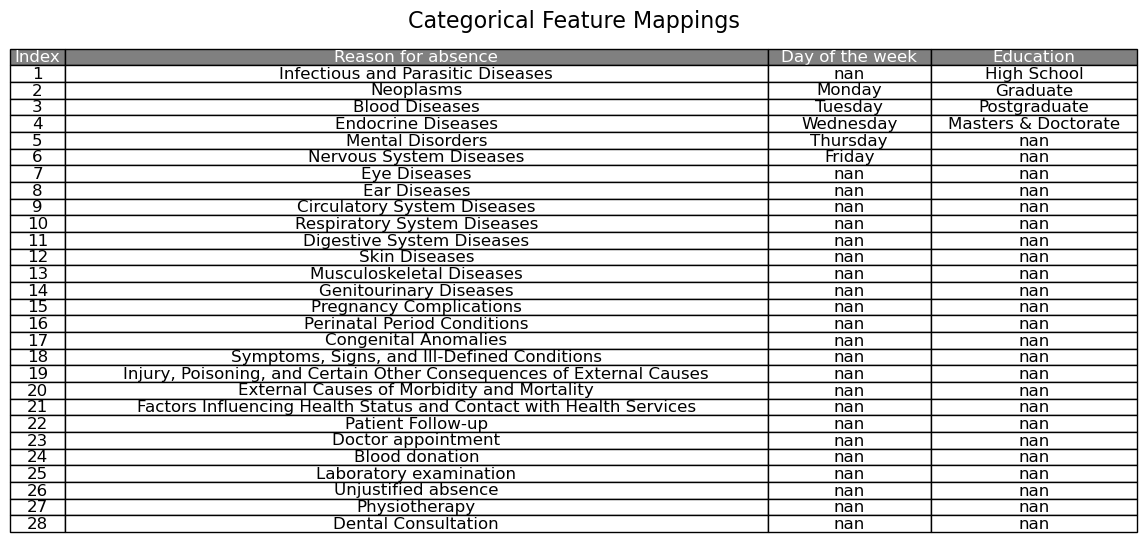

In [300]:
# Define the mapping for categorical features

reason_absence = {
    1: "Infectious and Parasitic Diseases",
    2: "Neoplasms",
    3: "Blood Diseases",
    4: "Endocrine Diseases",
    5: "Mental Disorders",
    6: "Nervous System Diseases",
    7: "Eye Diseases",
    8: "Ear Diseases",
    9: "Circulatory System Diseases",
    10: "Respiratory System Diseases",
    11: "Digestive System Diseases",
    12: "Skin Diseases",
    13: "Musculoskeletal Diseases",
    14: "Genitourinary Diseases",
    15: "Pregnancy Complications",
    16: "Perinatal Period Conditions",
    17: "Congenital Anomalies",
    18: "Symptoms, Signs, and Ill-Defined Conditions",
    19: "Injury, Poisoning, and Certain Other Consequences of External Causes",
    20: "External Causes of Morbidity and Mortality",
    21: "Factors Influencing Health Status and Contact with Health Services",
    22: "Patient Follow-up",
    23: "Doctor appointment",
    24: "Blood donation",
    25: "Laboratory examination",
    26: "Unjustified absence",
    27: "Physiotherapy",
    28: "Dental Consultation"
}

weekdays = {
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday'
}

education_mapping = {
    1: 'High School',
    2: 'Graduate',
    3: 'Postgraduate',
    4: 'Masters & Doctorate'
}

# Combine the mappings into a DataFrame
mapping_df = pd.DataFrame({
    'Reason for absence': pd.Series(reason_absence),
    'Day of the week': pd.Series(weekdays),
    'Education': pd.Series(education_mapping)
})

mapping_df.reset_index(inplace=True)
mapping_df.rename(columns={'index': 'Index'}, inplace=True)

# Visualize the mapping

figure, ax = plt.subplots(figsize=(10, 5))
# Hide the axes
ax.axis('off')

# Create the table
table = ax.table(cellText=mapping_df.values,
                 colLabels=mapping_df.columns,
                 cellLoc='center',
                 loc='center')

# Apply gray color to the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_facecolor('gray')
        cell.set_text_props(color='white')

# Adjust the font size
table.auto_set_font_size(False)
table.set_fontsize(12)

# Adjust the column width
table.auto_set_column_width(col=list(range(len(mapping_df.columns))))

# Display the table
plt.text(0.5,1.2, 'Categorical Feature Mappings', ha='center', va='center', transform=ax.transAxes, fontsize=16)
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

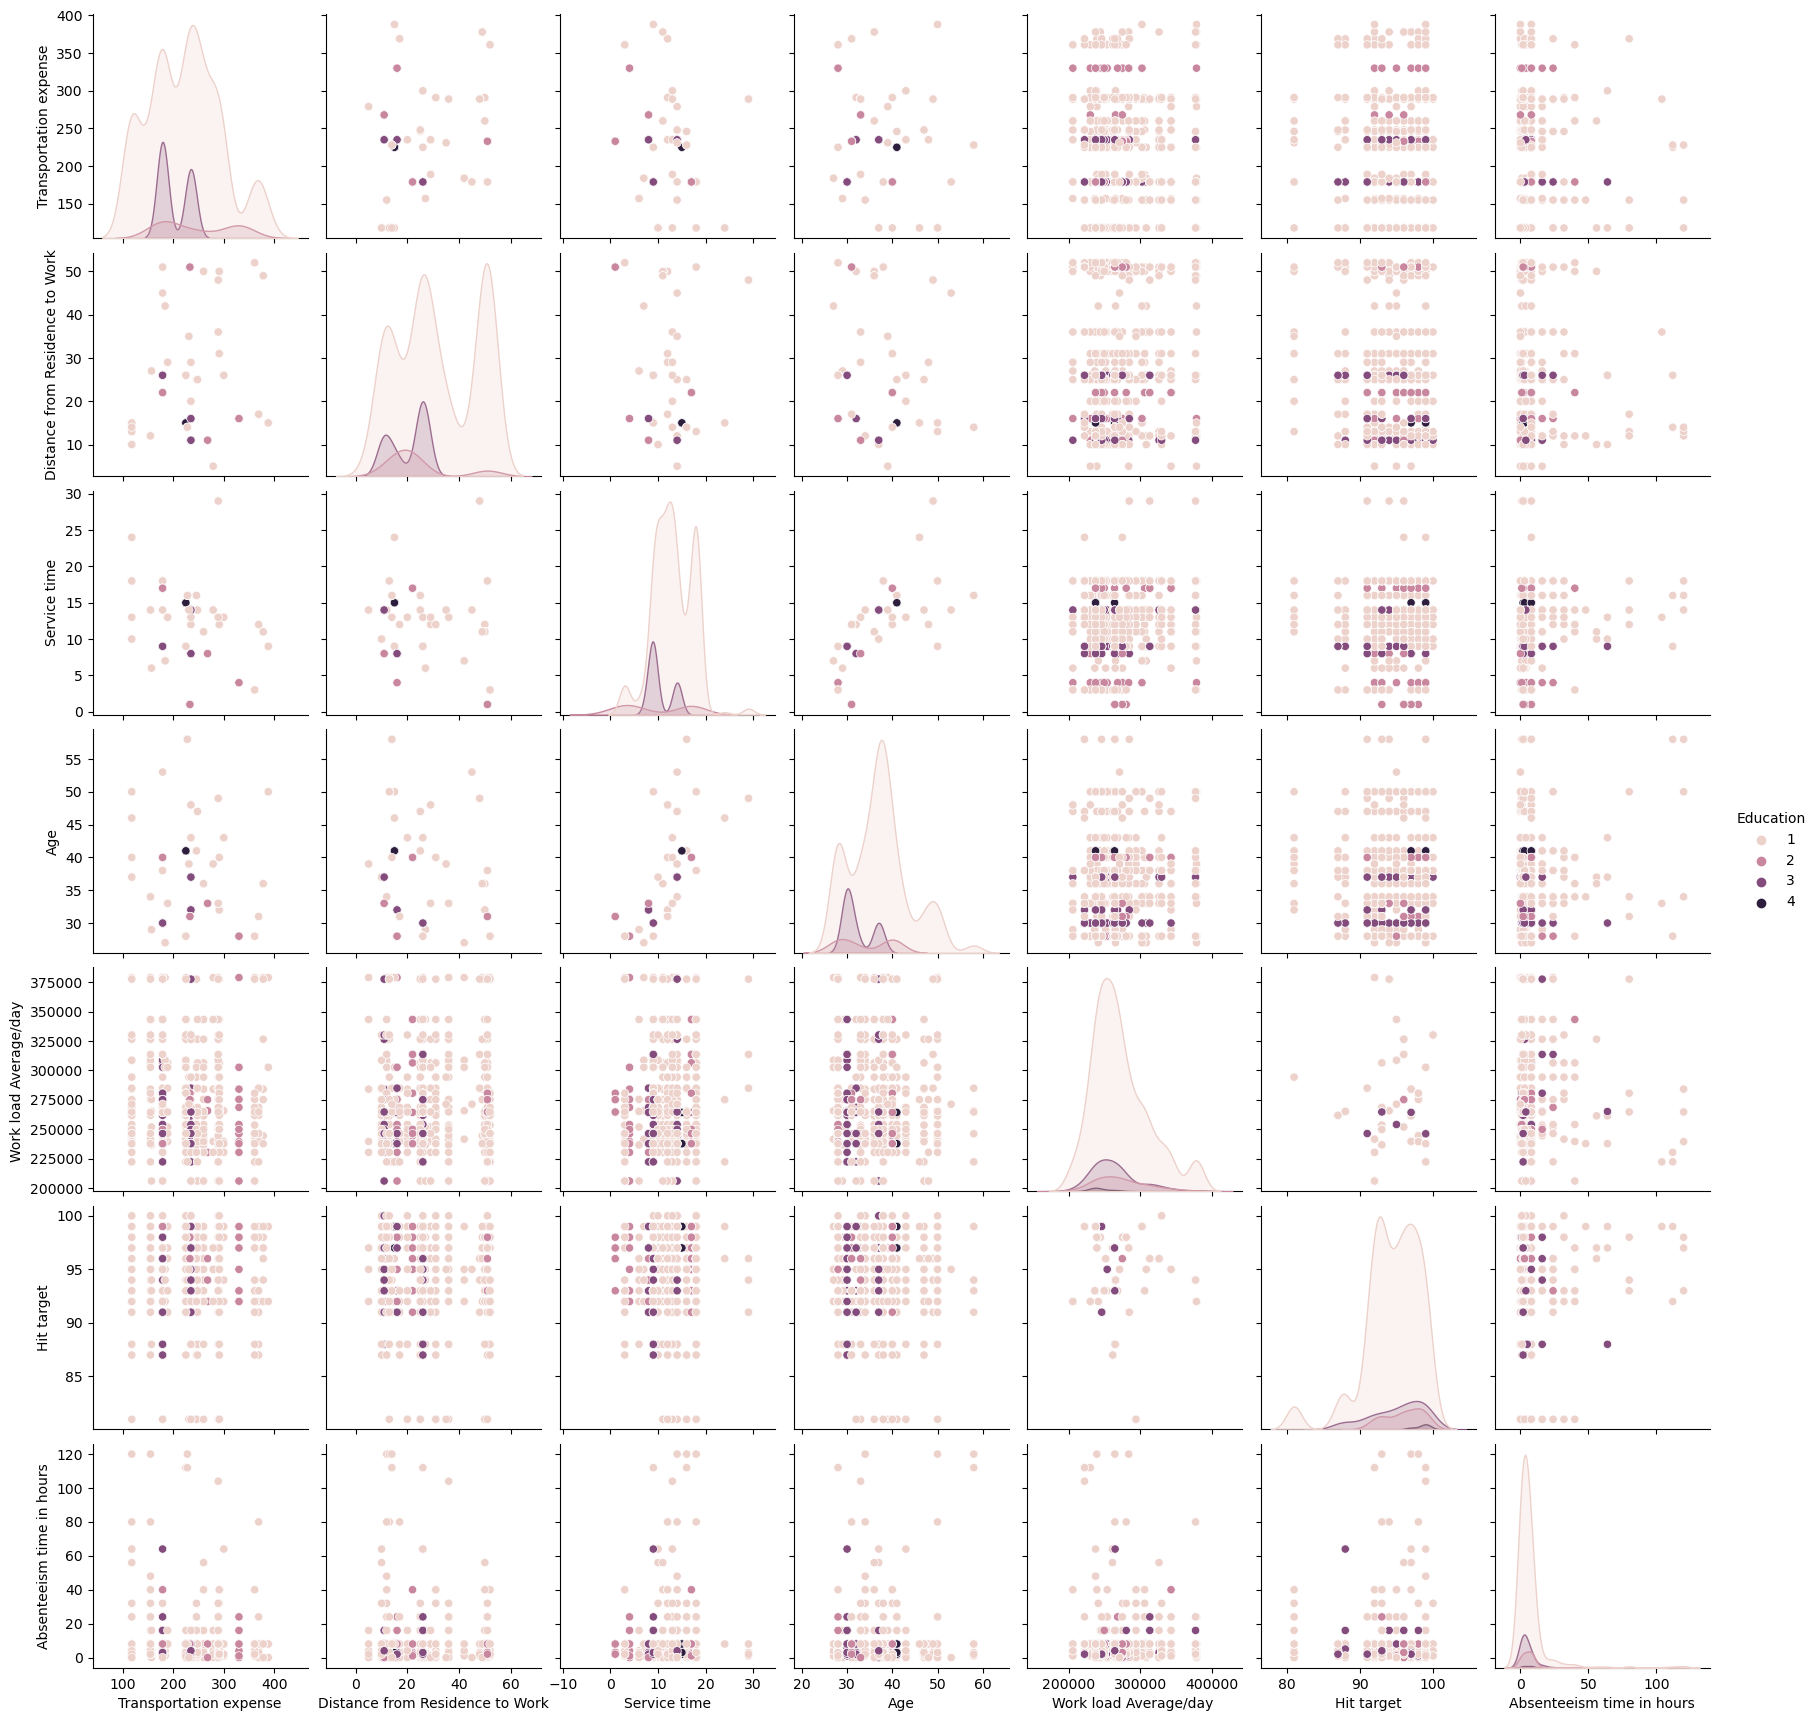

In [301]:
relevant_features = ['Transportation expense','Distance from Residence to Work','Service time','Age','Work load Average/day ','Hit target','Education','Absenteeism time in hours'] # Select prospective features
sns.pairplot(data[relevant_features], hue='Education', diag_kind='kde')
plt.show()

Abesenteeism time is not correlated with avg daily work load. Some instances of absenteeism are seen even when the workload is low.  

High school graduates are over-represented in the dataset while Masters and Ph.D graduates are underrepresented. This is not unusual for a courrier company which does not need high-skilled labor.

Let's scale the data and evaluate the performance of different clustering algorithms.  

We will then reduce the dimensionality using PCA and evaluated the same algorithms on this transformed data set.

# Scaling

Scaling all the numerical features.  
Only one ordinal feature - Education - hence, it would be pointless to scale this column
Nominal categorical features do not need to be scaled since these are already labeled with numeric indices. One Hot Encoding would have been ideal, but it would have blown up the dimensionality of the data set.

In [302]:
numeric_features = ['Transportation expense', 'Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day ', 'Hit target','Weight', 'Height', 'Body mass index', 'Absenteeism time in hours']
scaled_numeric_features = StandardScaler().fit_transform(data[numeric_features])
scaled_numeric_features_df = pd.DataFrame(scaled_numeric_features, columns=numeric_features)
data = pd.concat([data.drop(numeric_features, axis=1), scaled_numeric_features_df], axis=1)
data.head()


,Reason for absence,Month of absence,Day of the week,Seasons,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Weight,Height,Body mass index,Absenteeism time in hours
0,26,7,3,1,0,1,2,1,0,1,1.011408,0.429556,0.101770,-0.532868,-0.818212,0.638686,0.851673,-0.019046,0.775932,-0.219511
1,0,7,3,1,1,1,1,1,0,0,-1.544379,-1.121694,1.242825,2.092860,-0.818212,0.638686,1.473056,0.975828,1.009438,-0.519767
2,23,7,4,1,0,1,0,1,0,0,-0.632665,1.441240,1.242825,0.239405,-0.818212,0.638686,0.774000,-0.350671,1.009438,-0.369639
3,7,7,5,1,0,1,2,1,1,0,0.861947,-1.661258,0.329981,0.393859,-0.818212,0.638686,-0.857131,-0.682295,-0.625100,-0.219511
4,23,7,5,1,0,1,2,1,0,1,1.011408,0.429556,0.101770,-0.532868,-0.818212,0.638686,0.851673,-0.019046,0.775932,-0.369639


# Hierarchical Clustering

## Cluster determination using Dendron

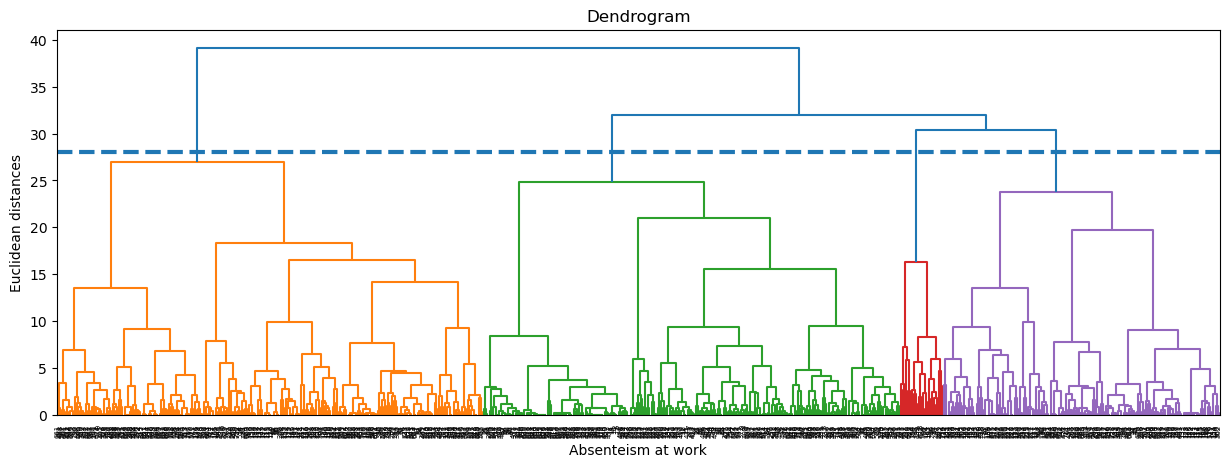

In [303]:
plt.figure(figsize=(15,5))
plt.title('Dendrogram')
plt.xlabel('Absenteism at work')
plt.ylabel('Euclidean distances')
plt.hlines(y=28,xmin=0,xmax=1000000,lw=3,linestyles='--')
#plt.grid(True)
dendrogram = sch.dendrogram(sch.linkage(data[relevant_features], method = 'ward'))
plt.show()

Cluster  = 4 is a potential candidate. Let's validate this with k-means

## Cluster determination with K-Means

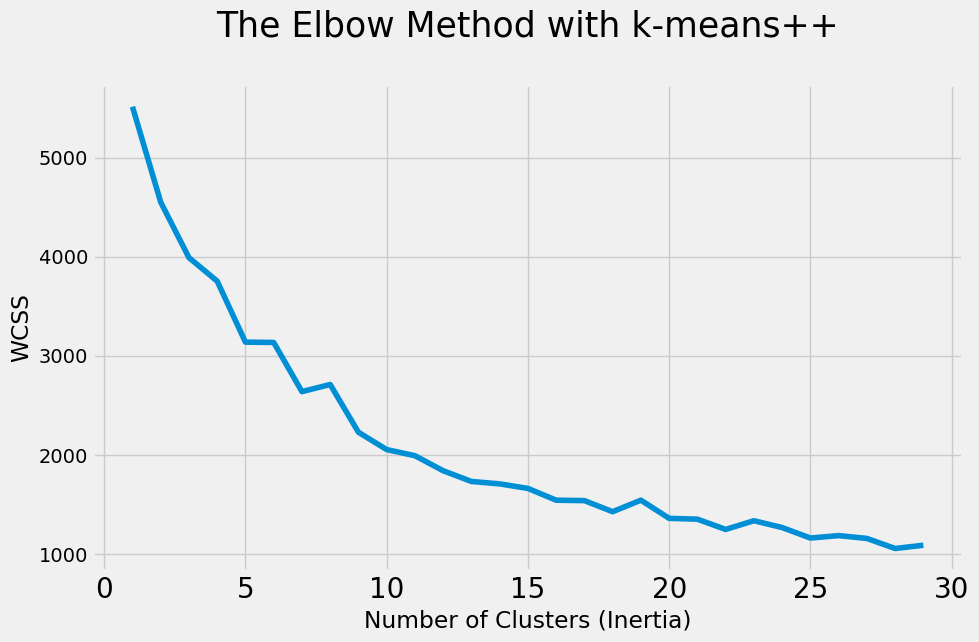

In [304]:
wcsse = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(data[relevant_features])
    wcsse.append(kmeans.inertia_)

with plt.style.context(('fivethirtyeight')):
    plt.figure(figsize=(10,6))
    plt.plot(range(1, 30), wcsse)
    plt.title('The Elbow Method with k-means++\n',fontsize=25)
    plt.xlabel('Number of Clusters (Inertia)')
    plt.xticks(fontsize=20)
    plt.ylabel('WCSS')
    #plt.vlines(x=5,ymin=0,ymax=250000,linestyles='--')
    #plt.text(x=5.5,y=110000,s='5 clusters',
             #fontsize=25,fontdict={'family':'Times New Roman'})
    plt.show()

The elbow is apparaent around K = 6. I will evaluate the model selecting this value of K.

### Train model with K = 6

In [305]:
# Fit model with K = 6
X = data[relevant_features] #train model on the previously selected subset of features
ac = AgglomerativeClustering(n_clusters= 6, metric='euclidean', linkage='ward')
ac.fit(X)

labels_ac = ac.labels_



labels_ac = ac.labels_

In [306]:
np.unique(labels_ac)

array([0, 1, 2, 3, 4, 5])

### Scatter plot

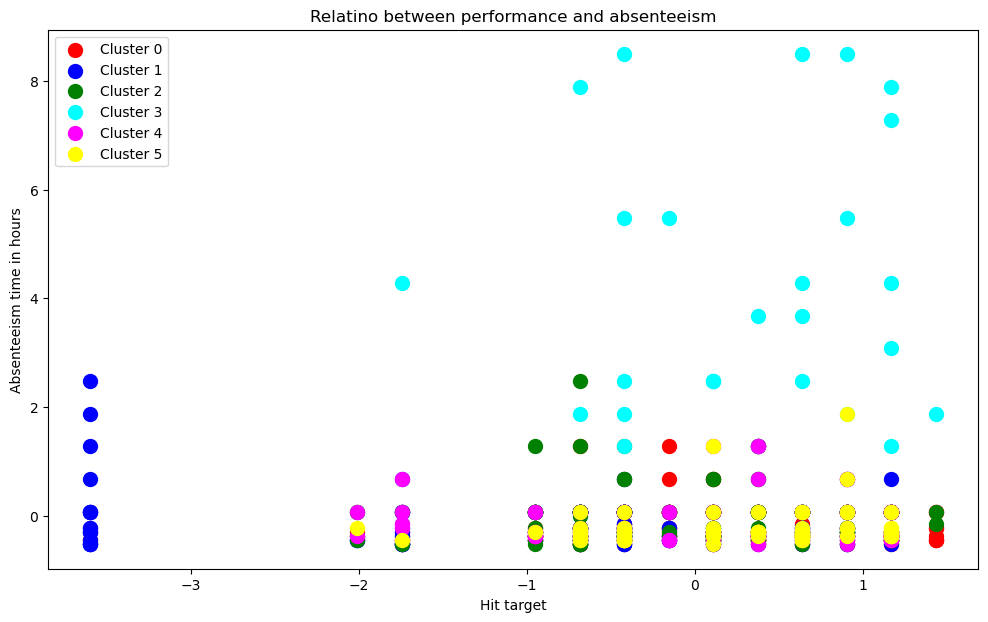

In [307]:
plt.figure(figsize=(12,7))
# Cluster 0
plt.scatter(X.loc[labels_ac == 0, X.columns[X.columns.get_loc('Hit target')]],X.loc[labels_ac == 0, X.columns[X.columns.get_loc('Absenteeism time in hours')]],s=100, c='red', label='Cluster 0')
# Cluster 1
plt.scatter(X.loc[labels_ac == 1, X.columns[X.columns.get_loc('Hit target')]], X.loc[labels_ac == 1, X.columns[X.columns.get_loc('Absenteeism time in hours')]], s=100, c='blue', label='Cluster 1')
# Cluster 2
plt.scatter(X.loc[labels_ac == 2, X.columns[X.columns.get_loc('Hit target')]], X.loc[labels_ac == 2, X.columns[X.columns.get_loc('Absenteeism time in hours')]], s=100, c='green', label='Cluster 2')
# Cluster 3
plt.scatter(X.loc[labels_ac == 3, X.columns[X.columns.get_loc('Hit target')]], X.loc[labels_ac == 3, X.columns[X.columns.get_loc('Absenteeism time in hours')]], s=100, c='cyan', label='Cluster 3')
# Cluster 4
plt.scatter(X.loc[labels_ac == 4, X.columns[X.columns.get_loc('Hit target')]], X.loc[labels_ac == 4, X.columns[X.columns.get_loc('Absenteeism time in hours')]], s=100, c='magenta', label='Cluster 4')
# Cluster 5
plt.scatter(X.loc[labels_ac == 5, X.columns[X.columns.get_loc('Hit target')]], X.loc[labels_ac == 5, X.columns[X.columns.get_loc('Absenteeism time in hours')]], s=100, c='yellow', label='Cluster 5')
plt.xlabel('Hit target')
plt.ylabel('Absenteeism time in hours')
plt.title('Relatino between performance and absenteeism')
plt.legend()
plt.show()

### Frequency of the clusters

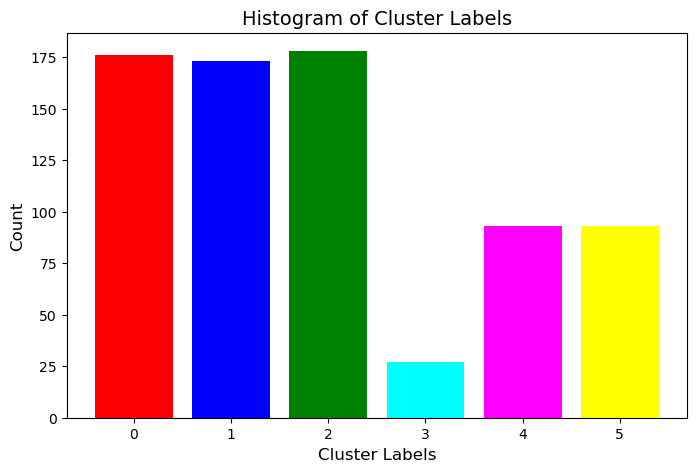

In [308]:
# Define the colors for each label (same as scatterplot)
label_colors = {
    0: 'red',    # Cluster 0 is red
    1: 'blue',   # Cluster 1 is blue
    2: 'green',   # Cluster 2 is green
    3: 'cyan',   # Cluster 3 is cyan
    4: 'magenta',   # Cluster 4 is magenta
    5: 'yellow'   # Cluster 5 is yellow
}

# Count the occurrences of each label
unique_labels, counts = np.unique(labels_ac, return_counts=True)

# Plot the histogram
plt.figure(figsize=(8, 5))
plt.bar(unique_labels, counts, color=[label_colors[label] for label in unique_labels])

# Add labels and title
plt.xlabel('Cluster Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Histogram of Cluster Labels', fontsize=14)
plt.xticks(unique_labels)  # Ensure the x-axis shows the cluster labels
plt.show()

Cluster 3 - high performance, high absensteeism - is outlier

Cluster 1 - low performance, low absenteeism - is sequestered properly

Rest of the clusters overlap with each other  

Visualization indicates the model performance is not satisfactory.

## Model evaluation using Silhouette score

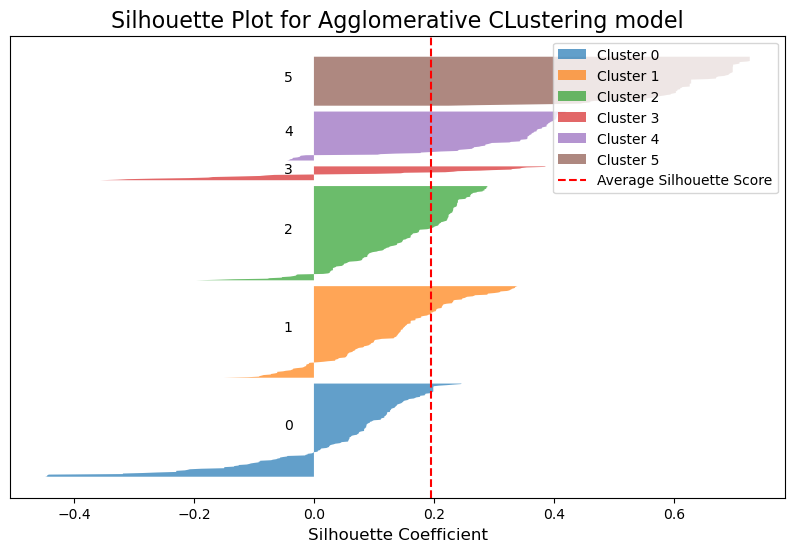

In [309]:
evaluate_model(X, 6, labels_ac)

Clusters with silhouette coefficients close to +1 are well-clustered. Only cluster 5 - high performance, low absenteeism - hits this criteria.  

Rest of the clusters have low silhouette coefficients, indicating that the points in these clusters are either assigned to the wrong cluster or the points dwell near the decision boundary.  

The silhouette score affirms our interpretation of the visualization that the model performance is poor. 

Let's try DBSCAN

# DBSCAN

## Find optimum eps value

In [310]:
# Loop for eps values
epsilon_range = np.linspace(0.001,5,50)
min_samples = 2 * X.shape[1]
outliers = [] #initialize empty list of outlier counts

for eps in epsilon_range:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels_dbscan = dbscan.fit_predict(X)
    number_of_outliers = len(X[labels_dbscan == -1])
    outliers.append(number_of_outliers)
    

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


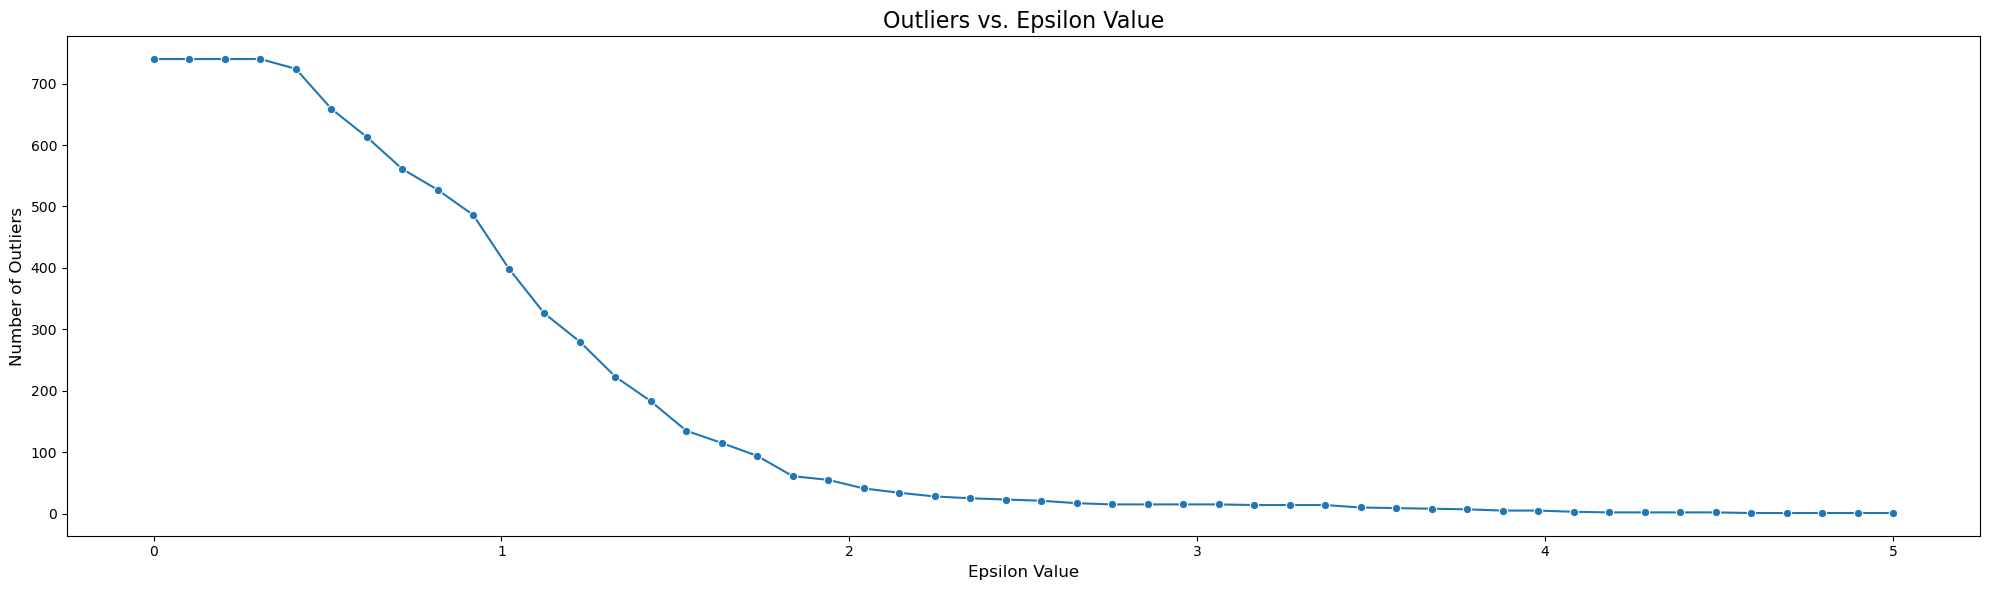

In [311]:
# Outlier points vs. eps value lineplot
plt.figure(figsize=(20, 6))
sns.lineplot(x=epsilon_range, y=outliers, marker='o')
plt.title('Outliers vs. Epsilon Value', fontsize=16)
plt.xlabel('Epsilon Value', fontsize=12)
plt.ylabel('Number of Outliers', fontsize=12)
plt.tight_layout()
plt.show()

Choosing eps = 2.5

## Visualize optimum DBSCAN model

In [312]:
# train new DBSCAN model
dbscan_2 = DBSCAN(eps=2, min_samples=min_samples)
labels_dbscan_2 = dbscan_2.fit_predict(X)

In [313]:
X_dbscan = X.copy()
X_dbscan.insert(0, 'DBSCAN Cluster', labels_dbscan_2)
np.unique(labels_dbscan_2)

array([-1,  0,  1])

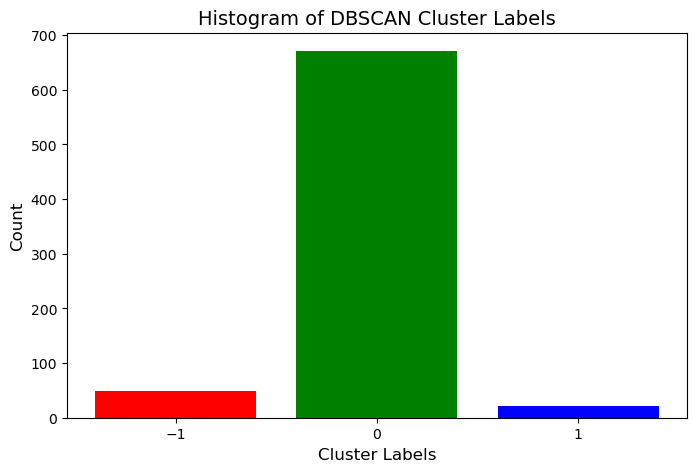

In [314]:
unique_labels_dbscan, counts_dbscan = np.unique(labels_dbscan_2, return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique_labels_dbscan, counts_dbscan, color=['red','green','blue'])
plt.xlabel('Cluster Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Histogram of DBSCAN Cluster Labels', fontsize=14)
plt.xticks(unique_labels_dbscan)
plt.show()

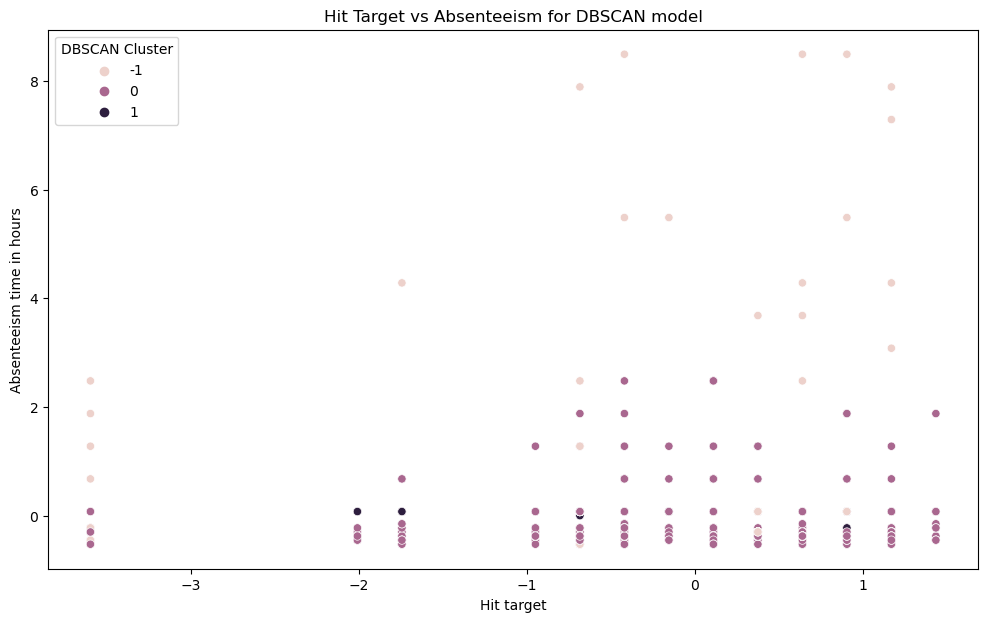

In [315]:
# Plot Hit Target vs Absenteeism for DBSCAN model
plt.figure(figsize=(12,7))
plt.title('Hit Target vs Absenteeism for DBSCAN model')
sns.scatterplot(data=X_dbscan, x='Hit target', y='Absenteeism time in hours', hue='DBSCAN Cluster')
plt.show()

DBSCAN appeas to be good at identifying outliers (high performance, high absenteeism) and low absenteeism, but it is not good at identifying low performance - low absenteeism.

## DBSCAN evaluation using Silhouette score

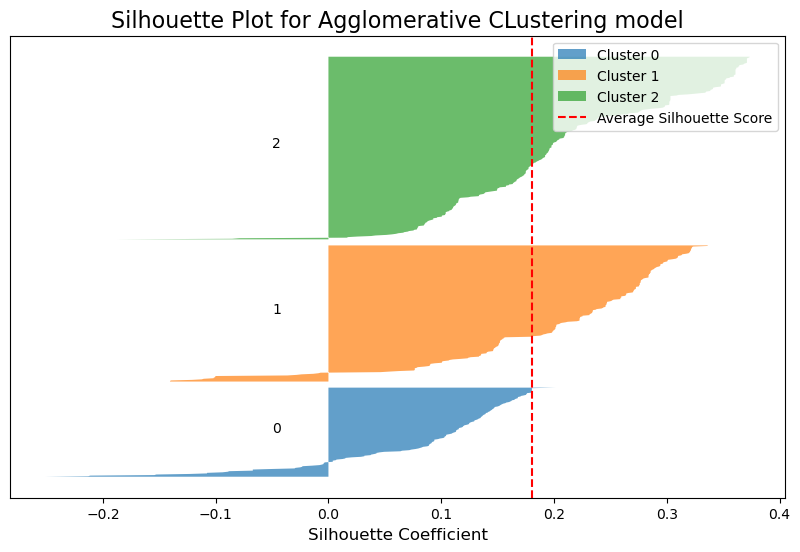

In [316]:
evaluate_model(X_dbscan,3,labels_dbscan_2)

The model performed worse than Hierarchical clustering.  

The distance relationships between the data points in the dataset might not be meaningful for clustering. Let's try one more run at clustering by reducing the dimensionality with PCA.

# PCA

## Variance explained by the number of components

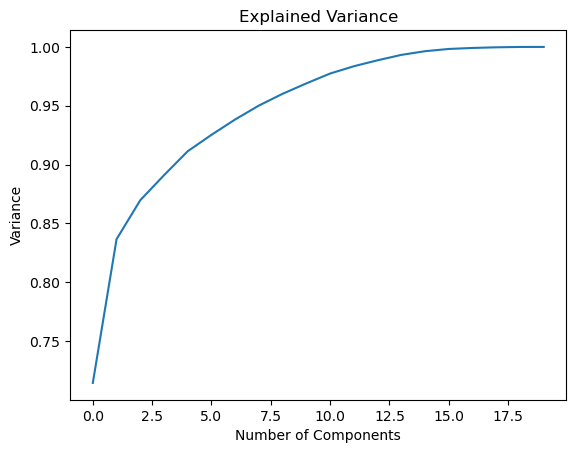

In [317]:
pca_1 = PCA().fit(data) #reducing dimensionality of the original dataset
plt.plot(np.cumsum(pca_1.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance')
plt.title('Explained Variance')
plt.show()

2 principal components explain roughly 80% of the variance

In [318]:
#initialize PCA with the optimum number of components
pca_2 = PCA(n_components=2)
pca_data = pca_2.fit_transform(data) #fitting and transforming the data

## Hierarchical clustering with clusters = 4

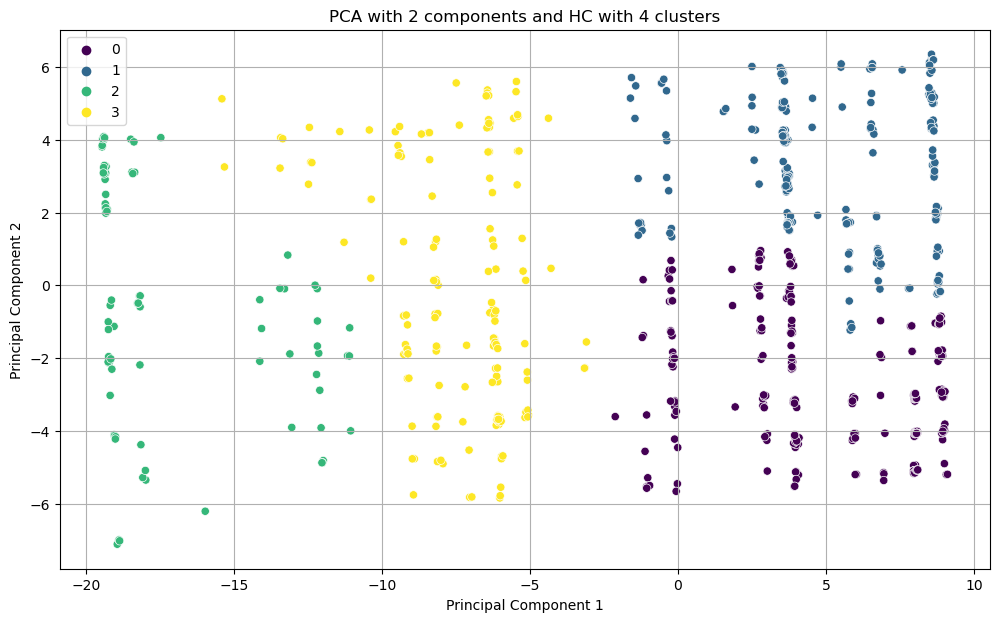

In [319]:
hc_4 = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels_hc_4 = hc_4.fit_predict(pca_data)

plt.figure(figsize=(12,7))
plt.title('PCA with 2 components and HC with 4 clusters')
sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], hue=labels_hc_4, palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

Clustering is noticeably better than before, but still there is overlap between the clusters and the intra-cluster distance is quite high.

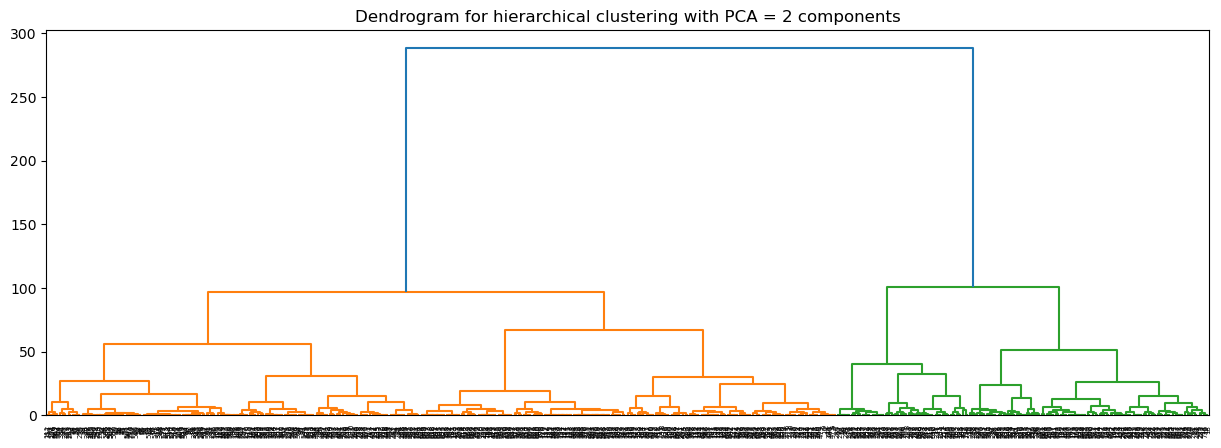

In [322]:
# plot dendogram
plt.figure(figsize=(15,5))
plt.title('Dendrogram for hierarchical clustering with PCA = 2 components')
sch.dendrogram(sch.linkage(pca_data, method='ward'))
plt.show()

The clusters in the dendrogram are noticeably clearer than the original dataset.

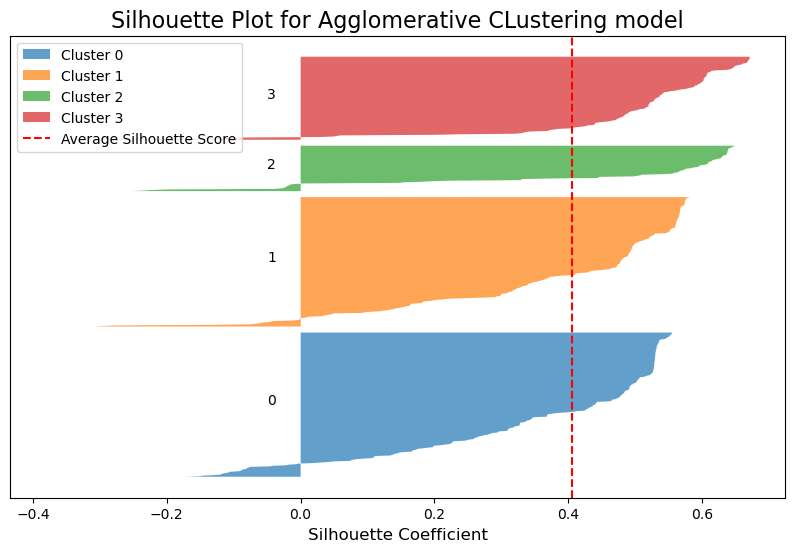

In [324]:
# Evaluate pca transformed and hierarchically clustered data with silhouette score  metric

evaluate_model(pca_data, 4, labels_hc_4)

This is significantly better than HC with 6 clusters and no PCA. Let's compare this with HC with 4 clusters and no PCA

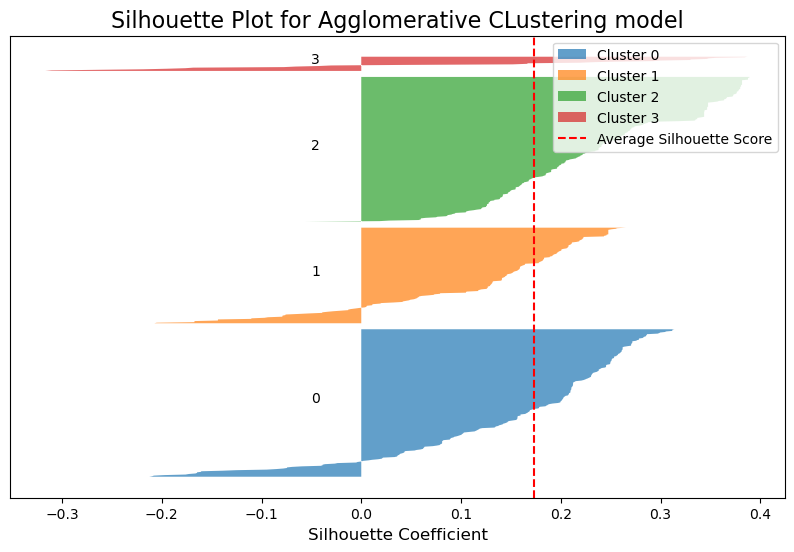

In [325]:
ac_4 = AgglomerativeClustering(n_clusters=4, linkage='ward')
ac_4.fit(X)
labels_ac_4 = ac_4.labels_

evaluate_model(X, 4, labels_ac_4)

The improvement in model performance with PCA could not be clearer.

## Hierarchical clustering with clusters = 6

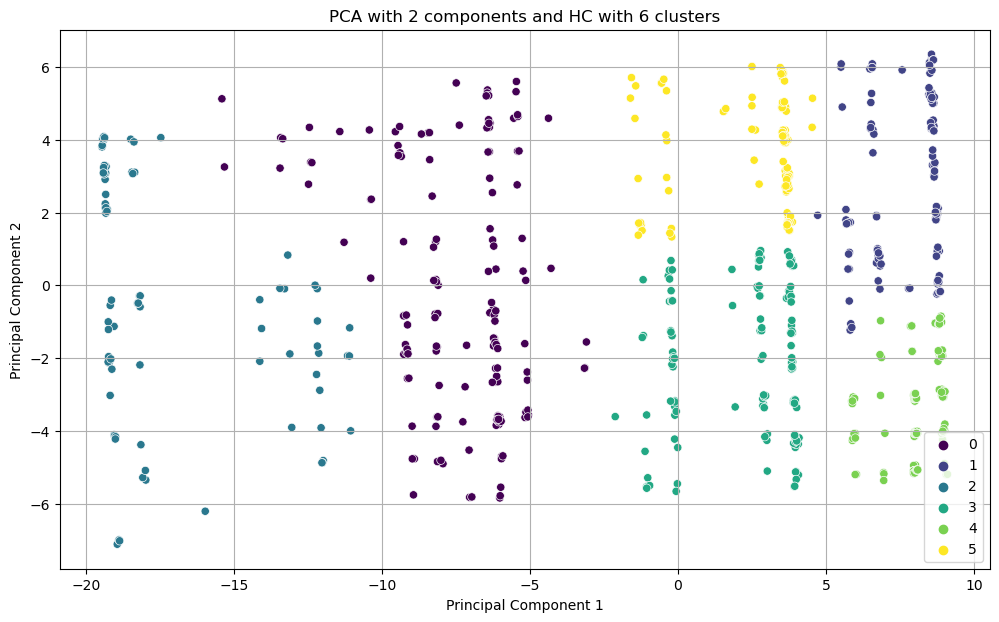

In [323]:
hc_6 = AgglomerativeClustering(n_clusters=6, linkage='ward')
labels_hc_6 = hc_6.fit_predict(pca_data)

plt.figure(figsize=(12,7))
plt.title('PCA with 2 components and HC with 6 clusters')
sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], hue=labels_hc_6, palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

Not surprisingly, increasing the number of clusters degrades the clustering.